# Introduction

The goal of this project is to study the generalisation of optimization algorithms in Deep Learning. For that we worked on the problem of classification of [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It provides 60000 32x32-pixel images, classified into 10 categories.
We built 2 CNNs for the approximation. One of the neural networks used is from a [Pytorch tutorial](https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html)

# Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.optimizer import Optimizer
import seaborn as sns

# Download the dataset


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
  car  frog plane  bird


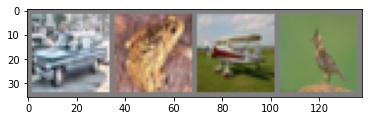

In [ ]:
transform = transforms.Compose(
	[transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
										download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
											shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
										download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
											shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
			'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

# Implementation of optimizers

## SAG

In [ ]:
class SAG(Optimizer):

  def __init__(self, params, lr=0.1, n=100, decay=1e-6):
    if lr <= 0.0:
      raise ValueError("Invalid learning rate: {}".format(lr))
    
    defaults = dict(lr=lr, decay=decay)
    self.batch_num = 0
    self.n_sample = n
    super(SAG, self).__init__(params, defaults)


  def set_batch_num(self, n):
    self.batch_num = n
  

  @torch.no_grad()
  def step(self, closure=None):

    loss = None
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue
        grad = p.grad
        if grad.is_sparse:
          raise RuntimeError("SAG does not support sparse gradients")
        
        p_state = self.state[p]

        #State initialization during first call
        if len(p_state) == 0:
          p_state['memory_grad'] = dict()                 
          p_state['average_grad'] = torch.zeros_like(p)
          

        grad_memo = p_state['memory_grad']
        if self.batch_num not in grad_memo.keys():
          grad_memo[self.batch_num] = grad.clone()

        old_grad = grad_memo[self.batch_num]
        p_state['average_grad'].add_(grad.sub(old_grad), alpha=1/self.n_sample)

        # Update
        if group['decay'] != 0.0:
            p.add_(p, alpha=-group['decay'])
        p.add_(p_state['average_grad'], alpha = -group['lr'])
        p_state['memory_grad'][self.batch_num].copy_(grad)

    return loss


## SVRG

In [ ]:
class SVRG(Optimizer):

  def __init__(self, params, lr=0.1, decay=1e-6, n_avg=1, n_updates=100):
    if lr <= 0.0:
      raise ValueError("Invalid learning rate: {}".format(lr))
    
    defaults = dict(lr=lr, decay=decay, n_avg=n_avg, n_updates=n_updates)
    self._avg = 0
    self._n_avg = n_avg
    self._update = n_updates
    self._n_updates = n_updates
    super(SVRG, self).__init__(params, defaults)
  

  @torch.no_grad()
  def step(self, closure=None):

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue
        grad = p.grad
        if grad.is_sparse:
          raise RuntimeError("SVRG does not support sparse gradients")
        
        p_state = self.state[p]

        #State initialization during first call
        if len(p_state) == 0:
          p_state['full_grad'] = torch.zeros_like(p)
          p_state['mini_b_grad'] = torch.zeros_like(p)
          p_state['old_update'] = p.clone()
          p_state['cur_update'] = torch.zeros_like(p)
        
        n_avg = group['n_avg']
        n_updates = group['n_updates']
        
        if self._avg < n_avg:
          p_state['full_grad'].copy_(grad)
        elif self._update == 0:
          if group['decay'] != 0.0:
            p.add_(p, alpha=-group['decay'])
          p.add_(p_state['full_grad'], alpha=-group['lr']) # update step
          p_state['cur_update'].copy_(p)
        else:
          p_state['mini_b_grad'].copy_(grad)
          p.data = p_state['old_update'].data
    
    loss = None

    if self._update != 0 and self._update < self._n_updates:
      if closure is not None:
        with torch.enable_grad():
          loss = closure()
      
      for group in self.param_groups:
        for p in group['params']:
          if p.grad is None:
            continue
          grad_i = p.grad
          p_state = self.state[p]
          n_avg = group['n_avg']
          n_updates = group['n_updates']

          old_p = p_state['old_update']
          p.data = p_state['cur_update'].data
          
          # update step
          if group['decay'] != 0.0:
            p.add_(p, alpha=-group['decay'])
          p.add_(p_state['mini_b_grad'].sub(grad_i).add(p_state['full_grad']), alpha=-group['lr'])

          p_state['cur_update'].copy_(p)
          if self._update == n_updates-1:
            p_state['old_update'].copy_(p)
      
    if self._avg < self._n_avg:
      self._avg += 1
      self._update = 0
    else:
      self._update += 1
      if self._update == self._n_updates:
        self._avg = 0

    return loss


# CNN Models

In [ ]:
def cnn1():
  return nn.Sequential(nn.ZeroPad2d((0,0,1,2)),
                       nn.Conv2d(3,16,3), nn.ReLU(), 
                       nn.Conv2d(16,16,3), nn.ReLU(), nn.MaxPool2d(2),
                       nn.ZeroPad2d((0,0,1,2)),
                       nn.Conv2d(16,32,3), nn.ReLU(),
                       nn.Conv2d(32,32,3), nn.ReLU(), nn.MaxPool2d(2),
                       nn.Flatten(),
                       nn.Linear(1120,128), nn.ReLU(),
                       nn.Linear(128,10), nn.Softmax(dim=1))

In [ ]:
def cnn2():
  return nn.Sequential(nn.Conv2d(3,6,5), nn.ReLU(), nn.MaxPool2d(2,2),
                       nn.Conv2d(6,16,5), nn.ReLU(), nn.MaxPool2d(2,2),
                       nn.Flatten(),
                       nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
                       nn.Linear(120, 84), nn.ReLU(),
                       nn.Linear(84, 10))

# Training

## Creating the train  and test data set 

We will only work on 10% of the total images of the data set.

In [ ]:
# Reduce the dataset
trainset.data = trainset.data[:5000]
trainset.targets = trainset.targets[:5000]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset.targets),
											shuffle=False, num_workers=1)

for data in trainloader:
  inputs, labels = data
  X_train = inputs
  y_train = labels

In [ ]:
X_train.shape

torch.Size([5000, 3, 32, 32])

In [ ]:
# Divide the training set in batches
X_batches = []
y_batches = []
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
											shuffle=True, num_workers=1)

for data in trainloader:
  inputs, labels = data
  X_batches.append(inputs.float())
  y_batches.append(labels.long())

In [ ]:
print(X_batches[0].shape)
print(len(y_batches))

torch.Size([32, 3, 32, 32])
157


In [ ]:
# Same for test set
X_test_batches = []
y_test_batches = []
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
											shuffle=True, num_workers=1)

for data in testloader:
  inputs, labels = data
  X_test_batches.append(inputs.float())
  y_test_batches.append(labels.long())

In [ ]:
print(X_test_batches[0].shape)
print(len(y_test_batches))

torch.Size([100, 3, 32, 32])
100


In [ ]:
# GD Training Loop
model_GD = cnn2()
optimizer = optim.SGD(model_GD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

#loss_gd = []
loss_gd_test = []
#acc_gd = []
acc_gd_test = []
n_epoch = 50



for num_epoch in range(n_epoch):
  optimizer.zero_grad()
  hat_y = model_GD(X_train)
  loss = criterion(hat_y, y_train)
  loss.backward()
  optimizer.step()
  #_, pred = torch.max(hat_y, 1)
  #acc = torch.sum(pred == y_train) * 100 / len(y_train)
  #acc_gd.append(acc)
  #loss_gd.append(loss)
  # validation loss and acc
  loss_val = 0
  acc_val = 0
  for i in range(len(y_test_batches)):
    input, target = X_test_batches[i], y_test_batches[i]
    hat_y_test = model_GD(input)
    loss = criterion(hat_y_test, target)
    loss_val += loss.item()
    _, pred = torch.max(hat_y_test, 1)
    acc = torch.sum(pred == target) * 100 / len(target)
    acc_val += acc.item()
  loss_val /= len(y_test_batches)
  acc_val /= len(y_test_batches)
  acc_gd_test.append(acc_val)
  loss_gd_test.append(loss_val)


  if num_epoch % 10 == 0 or num_epoch == n_epoch-1:
    print("epoch {}, loss {}, acc {}".format(num_epoch, loss_gd_test[-1], round(acc_gd_test[-1],3)))

#plt.plot(loss_gd)
#plt.xlabel("epochs")
#plt.ylabel("loss")

epoch 0, loss 2.3048373246192932, acc 11.31
epoch 10, loss 2.3038151550292967, acc 11.64
epoch 20, loss 2.3028358674049376, acc 12.33
epoch 30, loss 2.3018269085884095, acc 13.63
epoch 40, loss 2.300623815059662, acc 15.09
epoch 49, loss 2.2992160534858703, acc 15.84


In [ ]:
# SGD Training Loop

model_SGD = cnn2()
optimizer = optim.SGD(model_SGD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

#loss_sgd = []
#acc_sgd = []
loss_sgd_test = []
acc_sgd_test = []
n_epoch = 50

for num_epoch in range(n_epoch):
  for i in range(len(y_batches)):
    j = np.random.randint(0, len(y_batches))
    input, target = X_batches[j], y_batches[j]
    optimizer.zero_grad()
    hat_y = model_SGD(input)
    loss = criterion(hat_y, target)
    loss.backward() 
    optimizer.step()
  # validation loss and accuracy
  loss_val = 0
  acc_val = 0
  for i in range(len(y_test_batches)):
    input, target = X_test_batches[i], y_test_batches[i]
    hat_y_test = model_SGD(input)
    loss = criterion(hat_y_test, target)
    loss_val += loss.item()
    _, pred = torch.max(hat_y_test, 1)
    acc = torch.sum(pred == target) * 100 / len(target)
    acc_val += acc.item()
  loss_val /= len(y_test_batches)
  acc_val /= len(y_test_batches)
  acc_sgd_test.append(acc_val)
  loss_sgd_test.append(loss_val)

  
  if num_epoch % 10 == 0 or num_epoch == n_epoch-1:
    print("epoch {}, loss {}, acc {}".format(num_epoch, loss_sgd_test[-1], acc_sgd_test[-1]))

#plt.plot(loss_sgd)

epoch 0, loss 2.0967545354366304, acc 21.43
epoch 10, loss 1.6170340812206268, acc 45.67
epoch 20, loss 2.8221309185028076, acc 44.73
epoch 30, loss 4.041049716472625, acc 44.19
epoch 40, loss 4.8885510993003845, acc 42.41
epoch 49, loss 4.946982786655426, acc 41.62


In [ ]:
# SAG Training Loop

model_SAG = cnn2()
optimizer = SAG(model_SAG.parameters(), lr=0.1, decay=1e-6, n=len(y_batches))
criterion = nn.CrossEntropyLoss()

#loss_sag = []
#acc_sag = []
loss_sag_test = []
acc_sag_test = []
n_epoch = 50


for num_epoch in range(n_epoch):
  for i in range(len(y_batches)):
    j = np.random.randint(0, len(y_batches))
    optimizer.set_batch_num(j)
    input, target = X_batches[j], y_batches[j]
    optimizer.zero_grad()
    hat_y = model_SAG(input)
    loss = criterion(hat_y, target)
    loss.backward() 
    optimizer.step()
  # validation loss and accuracy
  loss_val = 0
  acc_val = 0
  for i in range(len(y_test_batches)):
    input, target = X_test_batches[i], y_test_batches[i]
    hat_y_test = model_SAG(input)
    loss = criterion(hat_y_test, target)
    loss_val += loss.item()
    _, pred = torch.max(hat_y_test, 1)
    acc = torch.sum(pred == target) * 100 / len(target)
    acc_val += acc.item()
  loss_val /= len(y_test_batches)
  acc_val /= len(y_test_batches)
  acc_sag_test.append(acc_val)
  loss_sag_test.append(loss_val)

  if num_epoch % 10 == 0 or num_epoch == n_epoch-1:
    print("epoch {}, loss {}, acc {}".format(num_epoch, loss_sag_test[-1], acc_sag_test[-1]))


#plt.plot(loss_sag)
#plt.xlabel("epochs")
#plt.ylabel("loss")


epoch 0, loss 2.304345943927765, acc 10.03
epoch 10, loss 1.7759758818149567, acc 34.56
epoch 20, loss 1.8765591835975648, acc 40.82
epoch 30, loss 1.9855053305625916, acc 34.0
epoch 40, loss 3.3823411583900453, acc 39.47
epoch 49, loss 3.2320641136169432, acc 36.77


In [ ]:
# ASGD Training Loop

model_ASGD = cnn2()
optimizer = optim.ASGD(model_ASGD.parameters(), lr=0.1, lambd=1e-6)
criterion = nn.CrossEntropyLoss()

#loss_asgd = []
#acc_asgd = []
loss_asgd_test = []
acc_asgd_test = []
n_epoch = 50


for num_epoch in range(n_epoch):
  for i in range(len(y_batches)):
    j = np.random.randint(0, len(y_batches))
    input = X_batches[j]
    target = y_batches[j]
    optimizer.zero_grad()
    hat_y = model_ASGD(input)
    loss = criterion(hat_y, target)
    loss.backward() 
    optimizer.step()
  # validation loss and accuracy
  loss_val = 0
  acc_val = 0
  for i in range(len(y_test_batches)):
    input, target = X_test_batches[i], y_test_batches[i]
    hat_y_test = model_ASGD(input)
    loss = criterion(hat_y_test, target)
    loss_val += loss.item()
    _, pred = torch.max(hat_y_test, 1)
    acc = torch.sum(pred == target) * 100 / len(target)
    acc_val += acc.item()
  loss_val /= len(y_test_batches)
  acc_val /= len(y_test_batches)
  acc_asgd_test.append(acc_val)
  loss_asgd_test.append(loss_val)


  if num_epoch % 5 == 0 or num_epoch == n_epoch-1:
    print("epoch {}, loss {}, acc {}".format(num_epoch, loss_asgd_test[-1], acc_asgd_test[-1]))


#plt.plot(loss_asgd)
#plt.xlabel("epochs")
#plt.ylabel("loss")

epoch 0, loss 2.1657098960876464, acc 21.46
epoch 5, loss 1.7729805552959441, acc 36.44
epoch 10, loss 1.5694716465473175, acc 45.05
epoch 15, loss 2.1080996370315552, acc 43.64
epoch 20, loss 3.3081426215171814, acc 39.65
epoch 25, loss 3.3980148434638977, acc 41.37
epoch 30, loss 3.893684709072113, acc 42.16
epoch 35, loss 4.550903391838074, acc 40.11
epoch 40, loss 4.71772914648056, acc 40.46
epoch 45, loss 5.817176427841186, acc 39.81
epoch 49, loss 5.1421347832679745, acc 40.4


In [ ]:
# SVRG Training Loop

model_SVRG = cnn2()
optimizer = SVRG(model_SVRG.parameters(), lr=0.1, decay=1e-6, n_avg=1, n_updates=len(y_batches))
# n_avg equals to number of steps to compute full batch gradient
# n_updates equals to batches' number

#loss_svrg = []
#acc_svrg = []
loss_svrg_test = []
acc_svrg_test = []
n_epoch = 50

optimizer.zero_grad()
hat_y = model_SVRG(X_train)
loss = criterion(hat_y, y_train)
loss.backward()
optimizer.step()

for num_epoch in range(n_epoch):
  if num_epoch != 0:
    optimizer.zero_grad()
    hat_y = model_SVRG(X_train)
    loss = criterion(hat_y, y_train)
    loss.backward()
    optimizer.step()
    
  for i in range(len(y_batches)):
    j = np.random.randint(0, len(y_batches))
    input = X_batches[j]
    target = y_batches[j]
    optimizer.zero_grad()
    hat_y = model_SVRG(input)
    loss = criterion(hat_y, target)
    loss.backward()
    def closure():
      optimizer.zero_grad()
      output = model_SVRG(input)
      loss = criterion(output, target)
      loss.backward()
      return loss
    optimizer.step(closure)

  # validation loss and accuracy
  loss_val = 0
  acc_val = 0
  for i in range(len(y_test_batches)):
    input, target = X_test_batches[i], y_test_batches[i]
    hat_y_test = model_SVRG(input)
    loss = criterion(hat_y_test, target)
    loss_val += loss.item()
    _, pred = torch.max(hat_y_test, 1)
    acc = torch.sum(pred == target) * 100 / len(target)
    acc_val += acc.item()
  loss_val /= len(y_test_batches)
  acc_val /= len(y_test_batches)
  acc_svrg_test.append(acc_val)
  loss_svrg_test.append(loss_val)

  if num_epoch % 10 == 0 or num_epoch == n_epoch-1:
    print("epoch {}, loss {}, acc {}".format(num_epoch, loss_svrg_test[-1], acc_svrg_test[-1]))



#plt.plot(loss_svrg)
#plt.xlabel("epochs")
#plt.ylabel("loss")

epoch 0, loss 2.0561415255069733, acc 24.49
epoch 10, loss 1.706016013622284, acc 43.33
epoch 20, loss 2.4522072505950927, acc 39.41
epoch 30, loss 3.264305580854416, acc 39.4
epoch 40, loss 3.870604956150055, acc 40.19
epoch 49, loss 3.3021604800224305, acc 38.16


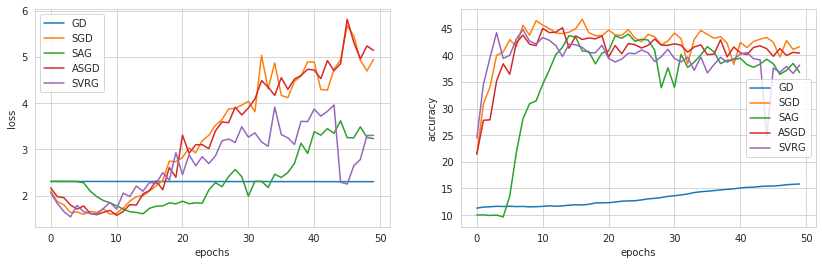

In [ ]:
# Comparison of validation score

sns.set_style("whitegrid")
loss_l = [loss_gd_test, loss_sgd_test, loss_sag_test, loss_asgd_test, loss_svrg_test]
acc_l = [acc_gd_test, acc_sgd_test, acc_sag_test, acc_asgd_test, acc_svrg_test]
opt_names = ["GD","SGD","SAG","ASGD","SVRG"]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)

for loss,name in zip(loss_l,opt_names):
  plt.plot(loss, label=name)
  plt.xlabel("epochs")
  plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)

for acc, name in zip(acc_l,opt_names):
  plt.plot(acc, label=name)
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
plt.legend()

plt.savefig("comparison on test set")

## Tests

In [ ]:
model = cnn2()
optimizer = SVRG(model.parameters(), lr=0.1, decay=0, n_avg=1, n_updates=len(y_batches))
criterion = nn.CrossEntropyLoss()
loss_l_svrg, acc_l_svrg = train_model(X_train, y_train, model, optimizer, criterion, opt_name="SVRG", n_batches=len(y_batches), n_epoch=50)

epoch 1, loss 1.8396371603012085, acc 30.72%
epoch 11, loss 2.04341459274292, acc 24.3%
epoch 21, loss 2.3177571296691895, acc 13.42%
epoch 31, loss 2.0301170349121094, acc 24.78%


In [ ]:
model = cnn2()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
loss_l_sgd, acc_l_sgd = train_model(X_train, y_train, model, optimizer, opt_name="SGD", lr=0.1, decay=0, n_batches=len(X_batches), n_epoch=50)

In [ ]:
model = cnn2()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
loss_l_sgd, acc_l_sgd = train_model(X_train, y_train, model, optimizer, opt_name="SGD", lr=0.1, decay=0, n_batches=len(X_batches), n_epoch=50)

In [ ]:
model = cnn2()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
loss_l_sgd, acc_l_sgd = train_model(X_train, y_train, model, optimizer, opt_name="SGD", lr=0.1, decay=0, n_batches=len(X_batches), n_epoch=50)

# Comparison on test set

In [ ]:
# Reduce the dataset
#testset.data = testset.data[:5000]
#trainset.targets = trainset.targets[:5000]

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset.targets),
											shuffle=False, num_workers=1)

for data in testloader:
  inputs, labels = data
  X_test = inputs
  y_test = labels

In [ ]:
print(X_test.shape)

torch.Size([10000, 3, 32, 32])


In [ ]:
# Divide the training set in batches
X_batches = []
y_batches = []

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
											shuffle=True, num_workers=1)

for data in testloader:
  inputs, labels = data
  X_batches.append(inputs.float())
  y_batches.append(labels.long())

In [ ]:
# GD 
#optimizer = optim.SGD(model_GD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

hat_y = model_GD(X_test)
loss = criterion(hat_y, y_test)
_, pred = torch.max(hat_y, 1)
acc = torch.sum(pred == y_test) * 100 / len(y_test)

print(acc)

tensor(11.7800)


In [ ]:
# SGD 
#optimizer = optim.SGD(model_SGD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

hat_y = model_SGD(X_test)
loss = criterion(hat_y, y_test)
_, pred = torch.max(hat_y, 1)
acc = torch.sum(pred == y_test) * 100 / len(y_test)

print(acc)

tensor(41.6200)


In [ ]:
# SAG 
#optimizer = optim.SGD(model_SGD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

hat_y = model_SAG(X_test)
loss = criterion(hat_y, y_test)
_, pred = torch.max(hat_y, 1)
acc = torch.sum(pred == y_test) * 100 / len(y_test)

print(acc)

tensor(39.2900)


In [ ]:
# ASGD 
#optimizer = optim.SGD(model_SGD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

hat_y = model_ASGD(X_test)
loss = criterion(hat_y, y_test)
_, pred = torch.max(hat_y, 1)
acc = torch.sum(pred == y_test) * 100 / len(y_test)

print(acc)

tensor(40.9900)


In [ ]:
# SVRG 
#optimizer = optim.SGD(model_SGD.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

hat_y = model_SVRG(X_test)
loss = criterion(hat_y, y_test)
_, pred = torch.max(hat_y, 1)
acc = torch.sum(pred == y_test) * 100 / len(y_test)

print(acc)

tensor(38.1600)
